In [1]:
import warnings
from IPython.core.interactiveshell import InteractiveShell
from bs4 import BeautifulSoup

# https://github.com/WillKoehrsen/recurrent-neural-networks/blob/master/notebooks/Deep%20Dive%20into%20Recurrent%20Neural%20Networks.ipynb
InteractiveShell.ast_node_interactivity = 'all'

warnings.filterwarnings('ignore', category=RuntimeWarning)

RANDOM_STATE = 50
EPOCHS = 100
BATCH_SIZE = 2048
TRAINING_LENGTH = 20
TRAIN_FRACTION = 0.7
LSTM_CELLS = 16
VERBOSE = 1
MIN_WORD_COUNT = 10
SAVE_MODEL = True

In [2]:
import pandas as pd
import numpy as np
import pickle

In [3]:
anime_data = pd.read_csv("./data/anime_dataset.csv")

In [4]:
anime_data.head(1)

,Anime_id,Title,Genre,Synopsis,Type,Producer,Studio,Rating,ScoredBy,Popularity,Members,Episodes,Source,Aired,Link
0,1,Cowboy Bebop,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...","In the year 2071, humanity has colonized sever...",TV,['Bandai Visual'],['Sunrise'],8.81,363889.0,39.0,704490.0,26.0,Original,"Apr 3, 1998 to Apr 24, 1999",https://myanimelist.net/anime/1/Cowboy_Bebop


In [5]:
anime_synopsis_column_name = "Synopsis"
anime_genre_column_name = "Genre"

In [6]:
def word_count(text):
    return len(text.split())

def is_over_min_word_count(text):
    return word_count(text) >= MIN_WORD_COUNT

In [7]:

anime_data.drop(anime_data[anime_data[anime_synopsis_column_name].isnull()].index, inplace=True)
anime_data.drop(anime_data[anime_data[anime_genre_column_name].isnull()].index, inplace=True)
anime_data.drop(anime_data[anime_data[anime_synopsis_column_name].apply(word_count) == 0].index, inplace=True)
anime_data.drop(anime_data[anime_data[anime_synopsis_column_name].apply(is_over_min_word_count) == False].index, inplace=True)
anime_data[anime_synopsis_column_name].isnull().sum()
anime_data[anime_genre_column_name].isnull().sum()

0

0

In [8]:
anime_synopsis = list(anime_data[anime_synopsis_column_name])

# Data cleaning

In [9]:
import re

# Stop words are words like "a", "the", or "in" which don't convey significant meaning.
# They're usually removed from text before processing.
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
    
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


In [10]:
def preprocess_phrase(sentance):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    return sentance.strip()

In [11]:
preprocess_phrase(anime_data[anime_synopsis_column_name][0])

'year humanity colonized several planets moons solar system leaving uninhabitable surface planet earth behind inter solar system police attempts keep peace galaxy aided part outlaw bounty hunters referred cowboys ragtag team aboard spaceship bebop two individuals mellow carefree spike spiegel balanced boisterous pragmatic partner jet black pair makes living chasing bounties collecting rewards thrown course addition new members meet travels ein genetically engineered highly intelligent welsh corgi femme fatale faye valentine enigmatic trickster memory loss strange computer whiz kid edward wong crew embarks thrilling adventures unravel member dark mysterious past little little well balanced high density action light hearted comedy cowboy bebop space western classic homage smooth improvised music named written mal rewrite'

This function “decontracted” defined above takes a text column from a data frame and removes all HTML tags and special characters.

In [12]:
preprocessed_synopsis = []
# we use stop words only for tasks like classification where we don't need the exact words
# but for text generation we need the exact words so we don't use stop words
# tqdm is for printing the status bar
for sentance in anime_data[anime_synopsis_column_name].values:
    processed_sentence = preprocess_phrase(sentance)
    preprocessed_synopsis.append(processed_sentence)

print(preprocessed_synopsis[0])

year humanity colonized several planets moons solar system leaving uninhabitable surface planet earth behind inter solar system police attempts keep peace galaxy aided part outlaw bounty hunters referred cowboys ragtag team aboard spaceship bebop two individuals mellow carefree spike spiegel balanced boisterous pragmatic partner jet black pair makes living chasing bounties collecting rewards thrown course addition new members meet travels ein genetically engineered highly intelligent welsh corgi femme fatale faye valentine enigmatic trickster memory loss strange computer whiz kid edward wong crew embarks thrilling adventures unravel member dark mysterious past little little well balanced high density action light hearted comedy cowboy bebop space western classic homage smooth improvised music named written mal rewrite


### Preprocess genres

In [13]:
def remove_spaces(x):
    x=x.split(",")
    nospace=[]
    for item in x:
        item=item.lstrip()
        nospace.append(item)
    return (",").join(nospace)

def remove_out_brackets(x):
    x=x.split(",")
    nospace=[]
    for item in x:
        item=item.replace("[","")
        item=item.replace("]","")
        nospace.append(item)
    return (",").join(nospace)

def remove_quote_mark(x):
    x=x.split(",")
    nospace=[]
    for item in x:
        item=item.replace("'","")
        nospace.append(item)
    return (",").join(nospace)
    


In [14]:
anime_data[anime_genre_column_name].isnull().sum()

0

In [15]:
anime_data[anime_genre_column_name]=anime_data[anime_genre_column_name].apply(remove_spaces)
anime_data[anime_genre_column_name]=anime_data[anime_genre_column_name].apply(remove_out_brackets)
anime_data[anime_genre_column_name]=anime_data[anime_genre_column_name].apply(remove_quote_mark)

In [16]:
anime_data[anime_genre_column_name].head(5)

0        Action,Adventure,Comedy,Drama,Sci-Fi,Space
1                 Action,Space,Drama,Mystery,Sci-Fi
2      Action,Sci-Fi,Adventure,Comedy,Drama,Shounen
3    Action,Magic,Police,Supernatural,Drama,Mystery
4            Adventure,Fantasy,Shounen,Supernatural
Name: Genre, dtype: object

In [17]:
genres = anime_data[anime_genre_column_name].unique()
filtered_genres = set()
for array in genres:
    for genre in array.split(","):
        filtered_genres.add(genre.strip())

# print(filtered_genres)
for genre in filtered_genres:
    with open("data/genres.txt", "a") as file:
        file.write(genre+"\n")

6

7

5

14

7

7

13

6

6

7

7

5

9

7

11

6

6

10

7

7

6

8

5

12

8

7

7

8

11

13

8

10

7

9

6

5

14

8

7

9

5

8

6

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary='true')
total_data = vectorizer.fit_transform(anime_data[anime_genre_column_name]).toarray()
total_data.shape

print(f"We have a total of {total_data.shape[1]} genres for {total_data.shape[0]} animes.")

(12193, 43)

We have a total of 43 genres for 12193 animes.


In [20]:
total_data # this is the label for our train data

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

# Create train and valid data

In [21]:
# The below is not needed as we are using the preprocessed synopsis

# def format_synopsis(synopsis):
#     """Add spaces around punctuation and remove references to images/citations."""

#     # Add spaces behind punctuation
#     synopsis = re.sub(r'(?<=[^\s0-9])(?=[.,;?"\'>\)\]])', r' ', synopsis)

#     # Add spaces before punctuation
#     # 's will not be split from the word
#     synopsis = re.sub(r'(?<=[.,;?"\'<\)\[])(?=[^\ss])', r' ', synopsis)


#     # Remove double spaces
#     synopsis = re.sub(r'\s\s', r' ', synopsis)

#     # Remove triple spaces
#     synopsis = re.sub(r'\s\s\s', r' ', synopsis)
#     return synopsis


In [22]:
# formatted_anime_synopsis = []

# # Iterate through all the original abstracts
# for synopsis in original_anime_synopsis:
#     # print(patent)
#     formatted_anime_synopsis.append(format_synopsis(synopsis))

# len(formatted_anime_synopsis)
# print(formatted_anime_synopsis[0])

In [23]:
from keras.preprocessing.text import Tokenizer

In [24]:

# things to consider when encoding
# https://wikidocs.net/44249

lower = True  # Whether to set the text to lowercase.
filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r'  # Characters to filter out of the text.


tokenizer = Tokenizer(lower=lower, filters=filters)
tokenizer.fit_on_texts(preprocessed_synopsis)
test = tokenizer.texts_to_sequences(preprocessed_synopsis)

### See raw tokenized results

In [25]:
print(tokenizer.word_index)

{'source': 1, 'one': 2, 'world': 3, 'not': 4, 'school': 5, 'new': 6, 'no': 7, 'life': 8, 'ann': 9, 'girl': 10, 'mal': 11, 'however': 12, 'story': 13, 'written': 14, 'rewrite': 15, 'two': 16, 'day': 17, 'time': 18, 'series': 19, 'young': 20, 'friends': 21, 'anime': 22, 'first': 23, 'high': 24, 'earth': 25, 'years': 26, 'video': 27, 'find': 28, 'girls': 29, 'named': 30, 'also': 31, 'love': 32, 'mysterious': 33, 'music': 34, 'boy': 35, 'family': 36, 'episode': 37, 'become': 38, 'must': 39, 'people': 40, 'man': 41, 'way': 42, 'japan': 43, 'anidb': 44, 'together': 45, 'help': 46, 'student': 47, 'city': 48, 'like': 49, 'year': 50, 'father': 51, 'three': 52, 'game': 53, 'called': 54, 'known': 55, 'back': 56, 'special': 57, 'short': 58, 'power': 59, 'get': 60, 'even': 61, 'based': 62, 'around': 63, 'war': 64, 'human': 65, 'group': 66, 'take': 67, 'friend': 68, 'home': 69, 'film': 70, 'make': 71, 'team': 72, 'song': 73, 'order': 74, 'lives': 75, 'little': 76, 'finds': 77, 'battle': 78, 'old': 7

### Analyze tokenzied result

In [26]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40176
등장 빈도가 2번 이하인 희귀 단어의 수: 22383
단어 집합에서 희귀 단어의 비율: 55.71236559139785
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.440063689293762


We do not need to have word encodings for words that appeared only twice at most. We will ignore them in our tokenizer

In [27]:
max_encoding_int = max([max(x) for x in test])
print(f"Max encoding integer: {max_encoding_int}")

Max encoding integer: 40176


In [28]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 17794


In [29]:
# restrict tokenzier to words that appear at least 3 times
tokenizer = Tokenizer(num_words=vocab_size ,lower=lower, filters=filters)
tokenizer.fit_on_texts(preprocessed_synopsis)
tokenized_anime_synopsis = tokenizer.texts_to_sequences(preprocessed_synopsis)

In [30]:
max_encoding_int = max([max(x) for x in tokenized_anime_synopsis])
print(f"Max encoding integer: {max_encoding_int}")

Max encoding integer: 17793


Now our encoding integer is fine-tuned

In [31]:
with open('anime_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

In [32]:
drop_train = [index for index, sentence in enumerate(tokenized_anime_synopsis) if len(sentence) < 1]
print(drop_train)

[]


In [33]:
from sklearn.utils import shuffle

print("synopsis count: ", len(tokenized_anime_synopsis), " genre count: " , len(total_data))
features, labels = shuffle(tokenized_anime_synopsis, total_data, random_state=RANDOM_STATE)
# Decide on number of samples for training
# TRAIN_FRACTION is 0.7
train_end = int(TRAIN_FRACTION * len(labels))
train_features = features[:train_end]
valid_features = features[train_end:]
train_labels = labels[:train_end]
print(train_labels)
valid_labels = labels[train_end:]

# Convert to arrays
X_train, X_valid = train_features, valid_features
y_train, y_valid = train_labels, valid_labels

# X_train.shape
# y_train.shape



synopsis count:  12193  genre count:  12193
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Pad sequences

서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다. 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보겠습니다.

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

리뷰의 최대 길이 : 236
리뷰의 평균 길이 : 40.447334504979494


(array([2.50e+02, 1.26e+03, 8.64e+02, 5.01e+02, 5.91e+02, 5.61e+02,
        4.39e+02, 5.24e+02, 4.75e+02, 3.22e+02, 3.25e+02, 3.09e+02,
        2.19e+02, 2.47e+02, 2.28e+02, 1.71e+02, 2.00e+02, 2.19e+02,
        1.31e+02, 1.52e+02, 1.49e+02, 7.60e+01, 7.30e+01, 7.80e+01,
        3.70e+01, 3.90e+01, 2.20e+01, 1.80e+01, 5.00e+00, 9.00e+00,
        6.00e+00, 8.00e+00, 7.00e+00, 3.00e+00, 2.00e+00, 3.00e+00,
        2.00e+00, 1.00e+00, 2.00e+00, 0.00e+00, 0.00e+00, 2.00e+00,
        0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00,
        1.00e+00, 2.00e+00]),
 array([  2.  ,   6.68,  11.36,  16.04,  20.72,  25.4 ,  30.08,  34.76,
         39.44,  44.12,  48.8 ,  53.48,  58.16,  62.84,  67.52,  72.2 ,
         76.88,  81.56,  86.24,  90.92,  95.6 , 100.28, 104.96, 109.64,
        114.32, 119.  , 123.68, 128.36, 133.04, 137.72, 142.4 , 147.08,
        151.76, 156.44, 161.12, 165.8 , 170.48, 175.16, 179.84, 184.52,
        189.2 , 193.88, 198.56, 203.24, 207.92, 212.6 , 217.28, 22

Text(0.5, 0, 'length of samples')

Text(0, 0.5, 'number of samples')

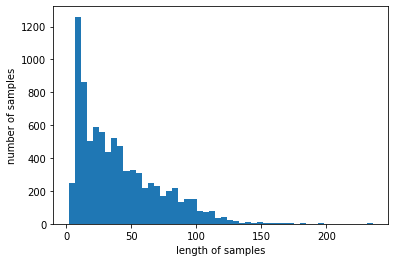

In [35]:
# reference: https://wikidocs.net/44249
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
avg = sum(map(len, X_train))/len(X_train)
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [36]:
import math
def below_threshold_len(max_len, nexted_list):
    count = 0
    for s in nexted_list:
        if(len(s) <= max_len):
            count = count + 1
    print(f"전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율: {(count / len(nexted_list))*100}")

max_len = math.floor(avg + 50)
below_threshold_len(max_len, X_train)


전체 샘플 중 길이가 90 이하인 샘플의 비율: 91.81019332161688


In [37]:
print(X_train[0])

[7251, 92, 1808, 397, 51, 1124, 1127, 9392, 89, 12523, 148, 246, 6348, 12524, 6, 51, 162, 3712, 7251, 943, 181, 71, 1165, 651, 3712, 1038, 911, 4398, 14886, 1059, 121, 33, 4695, 71, 1680, 1802, 192, 3700, 28, 89, 10891, 5894, 6348, 2968, 1186, 2120, 5298, 14887, 419, 4695, 9668, 705, 7251, 1137, 162, 986, 561, 2248, 28, 744, 884, 85, 997, 2155, 797, 7251, 6, 21, 140, 2178, 567, 847, 1298, 567, 1, 9]


In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen = max_len)
X_valid = pad_sequences(X_valid, maxlen = max_len)
X_train.shape, X_valid.shape
X_train

((8535, 90), (3658, 90))

array([[    0,     0,     0, ...,   567,     1,     9],
       [    0,     0,     0, ...,     1,  1120,  1006],
       [    0,     0,     0, ...,   717,  3970, 13737],
       ...,
       [    0,     0,     0, ...,    28,     1,  3648],
       [    0,     0,     0, ...,   137,  1936,  6924],
       [    0,     0,     0, ...,   549,  1240,  6399]], dtype=int32)

# Pre-Trained Embeddings

In [39]:
import os
from keras.utils import get_file

# Vectors to use
# glove_vectors = './glove.6B.zip'

# Download word embeddings if they are not present
# if not os.path.exists(glove_vectors):
#     glove_vectors = get_file('glove.6B.zip',
#                              'http://nlp.stanford.edu/data/glove.6B.zip')
#     os.system(f'unzip {glove_vectors}')

# Load in unzipped file
glove_vectors = '/Users/oztinman/rnn/synopsis_predictor/glove.6B/glove.6B.100d.txt'
glove = np.loadtxt(glove_vectors, dtype='str', comments=None)
glove.shape

(400001, 101)

Next we want to keep only those words that appear in our vocabulary. For words that are in our vocabulary but don't have an embedding, they will be represented as all 0s (a shortcoming that we can address by training our own embeddings.)

In [40]:
vectors = glove[:, 1:].astype('float')
words = glove[:, 0]

word_idx = dict(filter(lambda elem:elem[1] <= max_encoding_int, tokenizer.word_index.items()))
idx_word = dict(filter(lambda elem:elem[0] <= max_encoding_int, tokenizer.index_word.items()))
# idx_word = tokenizer.index_word
num_words = vocab_size # This is the newly updated vocab_size

# del glove
word_lookup = {word: vector for word, vector in zip(words, vectors)}

embedding_matrix = np.zeros((num_words, vectors.shape[1]))

not_found = 0

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector
    else:
        not_found += 1

print(f'There were {not_found} words without pre-trained embeddings.')

There were 2080 words without pre-trained embeddings.


In [41]:
embedding_matrix.shape

(17794, 100)

In [42]:
def find_closest(query, embedding_matrix, word_idx, idx_word, n=10):
    """Find closest words to a query word in embeddings"""

    idx = word_idx.get(query, None)
    # Handle case where query is not in vocab
    if idx is None:
        print(f'{query} not found in vocab.')
        return
    else:
        vec = embedding_matrix[idx]
        # Handle case where word doesn't have an embedding
        if np.all(vec == 0):
            print(f'{query} has no pre-trained embedding.')
            return
        else:
            # Calculate distance between vector and all others
            dists = np.dot(embedding_matrix, vec)

            # Sort indexes in reverse order
            idxs = np.argsort(dists)[::-1][:n]
            sorted_dists = dists[idxs]
            closest = [idx_word[i] for i in idxs]

    print(f'Query: {query}\n')
    max_len = max([len(i) for i in closest])
    # Print out the word and cosine distances
    for word, dist in zip(closest, sorted_dists):
        print(f'Word: {word:15} Cosine Similarity: {round(dist, 4)}')

In [43]:
find_closest('sword', embedding_matrix, word_idx, idx_word)

Query: sword

Word: sword           Cosine Similarity: 29.3167
Word: swords          Cosine Similarity: 20.7288
Word: dragon          Cosine Similarity: 19.6246
Word: knife           Cosine Similarity: 17.9398
Word: god             Cosine Similarity: 17.9074
Word: blade           Cosine Similarity: 17.7469
Word: spear           Cosine Similarity: 17.4721
Word: dagger          Cosine Similarity: 16.5624
Word: warrior         Cosine Similarity: 16.4934
Word: sorcery         Cosine Similarity: 15.9276


# Create Model

In [44]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

from keras.utils import plot_model

In [49]:
def make_word_level_model(num_words,
                          embedding_matrix,
                          n_classes
                          ):
    """Make a word level recurrent neural network with option for pretrained embeddings
       and varying numbers of LSTM cell layers."""

    model = Sequential()

    # Map words to an embedding
    model.add(Embedding(
        input_dim=num_words,
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],   
    ))

    model.add(LSTM(128, return_sequences=True))

    model.add(Dropout(0.5))

    model.add(LSTM(64))

    model.add(Dropout(0.5))

    # We have catgegories.
    model.add(Dense(n_classes, activation='sigmoid'))


    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model


model = make_word_level_model(
    num_words,
    embedding_matrix=embedding_matrix,
    n_classes=labels.shape[1])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 17794, 100)        1779400   
                                                                 
 lstm_3 (LSTM)               (None, 17794, 128)        117248    
                                                                 
 dropout_3 (Dropout)         (None, 17794, 128)        0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 43)                2795      
                                                                 
Total params: 1,948,851
Trainable params: 1,948,851
No

In [51]:
model_name = "anime_plot_genre_lstm"

In [52]:
def make_callbacks(model_name, save=SAVE_MODEL):
    """Make list of callbacks for training"""
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

    if save:
        callbacks.append(
            ModelCheckpoint(
                f'{model_name}.h5',
                save_best_only=True,
                save_weights_only=False))
    return callbacks

callbacks = make_callbacks(model_name)


In [55]:
X_train.shape
y_train.shape

(8535, 90)

(8535, 43)

In [56]:
X_valid.shape
y_valid.shape

(3658, 90)

(3658, 43)

In [57]:
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=32,
    verbose=True,
    callbacks=callbacks)

Epoch 1/5


ValueError: in user code:

    File "/Users/oztinman/opt/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/oztinman/opt/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/oztinman/opt/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/oztinman/opt/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/Users/oztinman/opt/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/oztinman/opt/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 17794), found shape=(None, 90)
